In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import MemorySaver

from pydantic import BaseModel
from typing_extensions import TypedDict, Annotated, Literal

import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
try:
    llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash', temperature=0.2)
    print(llm.invoke("What is a capital of Thailand?"))
except:
    ValueError (print("Op! something wrong about your model"))

content='The capital of Thailand is **Bangkok**.' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []} id='run--61fbe57e-f803-48f3-b04f-a804ac037ee8-0' usage_metadata={'input_tokens': 8, 'output_tokens': 33, 'total_tokens': 41, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 24}}


In [3]:
class State(TypedDict):
    messages : Annotated[list[str],add_messages]
    publish : str
    decision : str
    

In [4]:
state = State()
state['messages'] = "Travel to the mar is terrible"

In [5]:
def content_creator(state: State) -> State:

    print("--- Content Creator Agent ---")
    ''' Content creator agent tone for 15 year old '''
    system = """You are content creator agent, Your task is create high quality content from title that user given
                Your story must include at least 2 character. You content must proper to kids under 15
            """
    
    prompt = ChatPromptTemplate.from_messages([
        ("system",system),
        ("human","{messages}")
    ])
    
    chain = prompt | llm 

    result = chain.invoke({'messages': state["messages"]})

    return {'messages' : result.content, 'publish': result.content}

def refine_creator(state: State) -> State:

    print("--- Content Creator Agent ---")
    ''' Content creator agent tone for 15 year old '''
    system = """You are content creator agent, Your task is create high quality content from title that user given
                You tone must be professional and engaging.
            """
    
    prompt = ChatPromptTemplate.from_messages([
        ("system",system),
        ("human","{messages}")
    ])
    
    chain = prompt | llm 

    result = chain.invoke({'messages': state["messages"]})

    return {'messages' : result.content, 'publish': result.content}


In [6]:
def human_approve(state : State) -> Command[Literal[END, "refine_creator"]]:
    ''' Human approve the content '''
    
    values = interrupt({
                        "question":'''Is this pass your requirement?''',
                        "pre contetnt": state['publish'],
                        # "decision": state['decision']
                        })
    if values == "approved":
        print("--- Human Approve process ---")
        return Command(goto=END, update={"decision": "approved"})
    elif values == "rejected":
        print("--- Human Rejected process ---")
        return Command(goto="refine_creator", update={"decision": "rejected"})
    

In [ ]:
# def human_approve_fixed(state: State) -> Command[Literal[END, "refine_creator"]]:
#     ''' Human approve the content - Fixed version '''
    
#     values = interrupt({
#         "question": '''Is this pass your requirement?''',
#         "pre_content": state['publish'],
#     })
    
#     print(f"Human decision received: {values}")  # Debug print
    
#     # Handle different possible return values
#     if values == "approved" or str(values).lower() == "approved":
#         print("--- Human Approve process ---")
#         return Command(goto=END, update={"decision": "approved"})
#     else:  # Any other value (including "rejected") goes to refine
#         print("--- Human Rejected process ---")
#         return Command(goto="refine_creator", update={"decision": "rejected"})

In [ ]:
# # Create a new workflow with the fixed human approval function
# checkpointer_fixed = MemorySaver()

# graph_fixed = StateGraph(State)
# graph_fixed.add_node("content_creator", content_creator)
# graph_fixed.add_node("refine_creator", refine_creator)
# graph_fixed.add_node("human", human_approve_fixed)  # Use the fixed version

# graph_fixed.add_edge(START, "content_creator")
# graph_fixed.add_edge("content_creator", "human")
# graph_fixed.add_edge("human", END)

# workflow_fixed = graph_fixed.compile(checkpointer=checkpointer_fixed)

In [ ]:
# # Test the fixed workflow
# config_fixed = {"configurable": {"thread_id": 3}}

# # Start with a new content creation request
# result = workflow_fixed.invoke({"messages": "Learning to ride a bicycle"}, config=config_fixed)
# print("Content created, waiting for human approval...")

In [9]:
checkpointer = MemorySaver()

graph = StateGraph(State)
graph.add_node("content_creator", content_creator)
#####
graph.add_node("refine_creator", refine_creator)
graph.add_node("human",human_approve)
#####
graph.add_edge(START, "content_creator")
graph.add_edge("content_creator", "human")
graph.add_edge("human",END)
workflow = graph.compile(checkpointer=checkpointer)

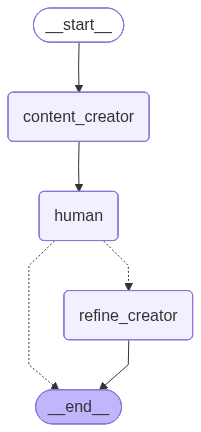

In [10]:
workflow

In [14]:
config = {"configurable": {"thread_id": 3}}

workflow.invoke({"messages":"get mention heealth with pets"}, config=config)

--- Content Creator Agent ---


{'messages': [HumanMessage(content='get mention heealth with pets', additional_kwargs={}, response_metadata={}, id='d3166c32-8948-4aa8-94f2-bd05fc3799ee'),
  HumanMessage(content='## The Wiggle-Waggle Wellness Plan\n\nLily sighed, flopping onto her beanbag chair. Outside, the sun was shining, but inside, she felt a bit… droopy. Her favorite book lay unread, and her drawing pad was empty.\n\nSuddenly, a wet nose nudged her hand. It was Pip, her fluffy, golden-brown terrier mix, with his tail doing a happy wiggle-waggle. Pip held a bright red squeaky ball in his mouth, his big brown eyes looking up at Lily expectantly.\n\n"Not now, Pip," Lily mumbled, trying to sound firm, but Pip just tilted his head, dropped the ball, and let out a soft "woof!" Then he nudged the ball with his nose towards the door.\n\nLily giggled. "You really want to play, don\'t you?"\n\nPip responded with another enthusiastic tail wag, a little bark, and then he trotted to the door, looking back at Lily as if to sa

In [15]:
r = workflow.invoke(Command(resume="approved"),config=config)

--- Human Approve process ---


In [16]:
print(r['messages'][-1].content)

## The Wiggle-Waggle Wellness Plan

Lily sighed, flopping onto her beanbag chair. Outside, the sun was shining, but inside, she felt a bit… droopy. Her favorite book lay unread, and her drawing pad was empty.

Suddenly, a wet nose nudged her hand. It was Pip, her fluffy, golden-brown terrier mix, with his tail doing a happy wiggle-waggle. Pip held a bright red squeaky ball in his mouth, his big brown eyes looking up at Lily expectantly.

"Not now, Pip," Lily mumbled, trying to sound firm, but Pip just tilted his head, dropped the ball, and let out a soft "woof!" Then he nudged the ball with his nose towards the door.

Lily giggled. "You really want to play, don't you?"

Pip responded with another enthusiastic tail wag, a little bark, and then he trotted to the door, looking back at Lily as if to say, "Come on!"

Lily couldn't resist. Pip always knew how to cheer her up. She grabbed his leash and her sneakers. "Alright, Pip! Park time!"

As soon as they stepped outside, Lily felt a litt

In [17]:
r

{'messages': [HumanMessage(content='get mention heealth with pets', additional_kwargs={}, response_metadata={}, id='d3166c32-8948-4aa8-94f2-bd05fc3799ee'),
  HumanMessage(content='## The Wiggle-Waggle Wellness Plan\n\nLily sighed, flopping onto her beanbag chair. Outside, the sun was shining, but inside, she felt a bit… droopy. Her favorite book lay unread, and her drawing pad was empty.\n\nSuddenly, a wet nose nudged her hand. It was Pip, her fluffy, golden-brown terrier mix, with his tail doing a happy wiggle-waggle. Pip held a bright red squeaky ball in his mouth, his big brown eyes looking up at Lily expectantly.\n\n"Not now, Pip," Lily mumbled, trying to sound firm, but Pip just tilted his head, dropped the ball, and let out a soft "woof!" Then he nudged the ball with his nose towards the door.\n\nLily giggled. "You really want to play, don\'t you?"\n\nPip responded with another enthusiastic tail wag, a little bark, and then he trotted to the door, looking back at Lily as if to sa